# Imports

In [20]:
import gc
import re
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
pd.set_option('display.max_columns', None)
import cv2

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from typing import List, Dict, Optional, Tuple, Any, Union

import wandb
from wandb.keras import WandbCallback

In [21]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Num GPUs Available:  2
Number of accelerators:  2


# Globals

In [22]:
# define path under which MURA-v1.1/ is located:
root_path: str = "/kaggle/input/mura-x-ray-dataset/"
os.chdir(root_path)
os.getcwd()

'/kaggle/input/mura-x-ray-dataset'

# Weights & Biases

In order to make experiment tracking easier we will use [Weights & Biases](wandb.ai/home), which offers a free lisence for academic purposes. For the sake of this assignment a team has been created:https://wandb.ai/aueb. Access can be granted by contacting the authors.

* Note that this code assumes that you have already set up a Wandb account and API key. If you haven't done so yet, you will need to sign up for a free account at https://wandb.ai/ and follow the instructions there to obtain your API key.



In [24]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Load Data

Data has the following structure:

```
├──MURA
  ├──train_image_paths.csv
  ├──train_labeled_studies.csv
  ├──valid_image_paths.csv
  ├──valid_labeled_studies.csv
  ├──train
  │   └─ BODY PART
  │       └─ patientxxx
  │          .
  │          .
  │          .
  │    .
  │    .
  │    .
  └──test
      └─ BODY PART
          └─ patientxxx
             .
             .
             .
       .
       .
       .  
```

We will create a dataframe that uses these paths as rows and extract any information needed.

In [25]:
def extract_set_category(string: str) -> dict:
    """
    Extracts the 'set_type' and 'category' from a given string using regular expressions.

    Parameters:
        string (str): A string containing the 'set' and 'category' information.

    Returns:
        dict: A dictionary containing the 'set' and 'category' information.
    """

    pattern = r".*(?P<set_type>train|valid)/(?P<category>XR_[A-Z]+)/(?P<patient_id>patient\d+)/study.*"
    match = re.match(pattern, string)
    if match:
        return {'set_type': match.group('set_type'), 'category': match.group('category'), 'patient_id': match.group('patient_id')}
    else:
        return None
    
def generate_path_df(dataset_type: str, dataset_path: str = "/kaggle/input/mura-x-ray-dataset/") -> pd.DataFrame:
    """
    Reads in the image paths and labels for a given dataset type (train or valid) from the MURA dataset.
    Returns a pandas DataFrame containing the image paths, labels, and the dataset type.
    
    Parameters:
        dataset_type (str): The type of dataset to read in (train or valid)
        dataset_path (str): The path to the MURA dataset folder (default: '/kaggle/input/mura-x-ray-dataset/')
    
    Returns:
        pd.DataFrame: A pandas DataFrame containing the image paths, labels, and dataset type.
    """
        
    # Read in the image paths csv file and assign the column name 'image_path'
    train_label_paths = pd.read_csv(f"{dataset_path}/MURA-v1.1/{dataset_type}_image_paths.csv", header=None, names=['image_path'])
    
    # Extract the path to the folder containing the image file and create a new column 'path'
    train_label_paths["path"] = train_label_paths.apply(lambda x: "/".join(x['image_path'].split("/")[:-1]) + "/", axis=1)
    
    # Read in the labeled studies csv file and assign column names 'path' and 'label'
    train_labels = pd.read_csv(f"{dataset_path}/MURA-v1.1/{dataset_type}_labeled_studies.csv", header=None, names=['path', 'label'])
    
    # Merge the two DataFrames on the 'path' column and create a new column 'image_type'
    _df = train_labels.merge(train_label_paths, on='path', how='left')
    
    # Check that the length of the two DataFrames match
    assert len(train_label_paths) == len(_df)
    
    return _df

def generate_dataframes(dataset_path: str = "/kaggle/input/mura-x-ray-dataset/") -> pd.DataFrame:
    """Perfoms actions needed to load the dataset with image paths and additional info"""
    
    # read train test_dataframe
    train: pd.DataFrame = generate_path_df(dataset_type="train")
    test: pd.DataFrame = generate_path_df(dataset_type="valid")

    # join dataframes
    _df = pd.concat([train, test]).reset_index()

    # Apply the extract_set_category function to each row of the DataFrame.
    _df = pd.concat([_df, pd.DataFrame(_df['path'].apply(lambda x: extract_set_category(x)).tolist())], axis=1)
    mapping: dict = {1: "abnormal", 0: "normal"}
    _df['label_type'] = _df['label'].apply(lambda x: mapping[x])
    
    
    # re-order columns
    cols = list(_df.columns)
    cols.remove("label")
    cols.append("label")
    _df = _df[cols]
    
    _df.drop(["index"], axis=1, inplace=True)
    
    return _df

In [26]:
data = generate_dataframes()
data.head()

,path,image_path,set_type,category,patient_id,label_type,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train,XR_SHOULDER,patient00001,abnormal,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train,XR_SHOULDER,patient00001,abnormal,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,train,XR_SHOULDER,patient00001,abnormal,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train,XR_SHOULDER,patient00002,abnormal,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,train,XR_SHOULDER,patient00002,abnormal,1


# Train Dev Test (valid) split

* in order not to have any dependencies on the order of the data, we will shuffle the data. Moreover, 10% of the input data will be used as validation and 10% as test.

As described in the Paper we will make sure not to have overlap between patients in the various sets. We shuffle the patients, and then split the dataset  

In [31]:
# take unique patient_ids and shuffle
patients = data.patient_id.unique()
np.random.seed(41)
np.random.shuffle(patients)

# split three list of patient_ids
length_80 = patients[:int(len(patients)*0.85)]
length_80_90 = patients[int(len(patients)*0.85):int(len(patients)*0.9)]
length_90_100 = patients[int(len(patients)*0.9):]

# sanity check
data.loc[data.patient_id.isin(length_80)].describe()\
.join(data.loc[data.patient_id.isin(length_80_90)].describe(),rsuffix="_Validation")\
.join(data.loc[data.patient_id.isin(length_90_100)].describe(), rsuffix="_Test")

,label,label_Validation,label_Test
count,34067.000000,1957.000000,3981.000000
mean,0.412041,0.375575,0.409696
std,0.492210,0.484395,0.491839
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


* Update the labels for each set & save dataframes to variables

In [32]:
# update labels
data.loc[data.patient_id.isin(length_80), "set_type"] = "train"
data.loc[data.patient_id.isin(length_80_90), "set_type"] = "validation"
data.loc[data.patient_id.isin(length_90_100), "set_type"] = "test"

train: pd.DataFrame = data.loc[data.set_type == 'train']
valid: pd.DataFrame = data.loc[data.set_type == 'validation']
test: pd.DataFrame = data.loc[data.set_type == 'test']

* visualize new class distribution. It seems that the selected seed provides a balanced set to train.

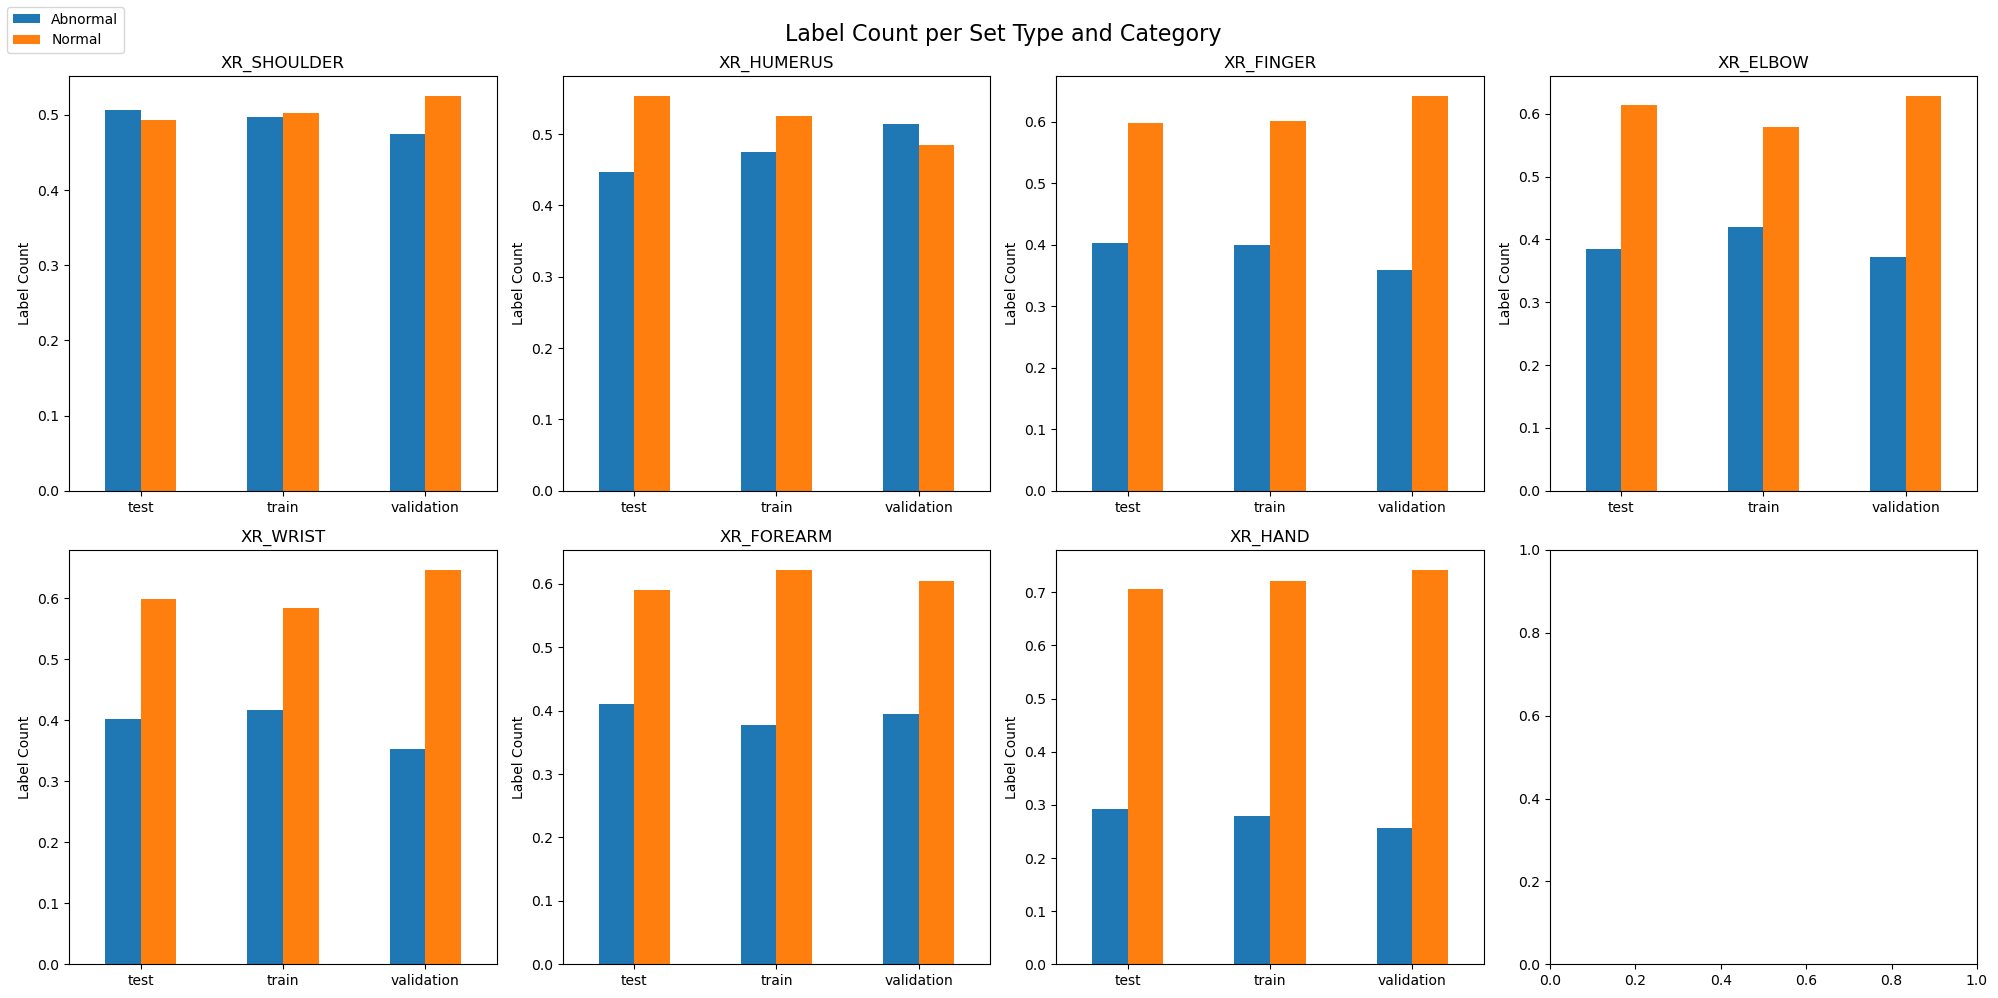

In [33]:
plot_label_counts(data)

# Data Augmentation

* As mentioned in the introductions, some pre-processing steps will take place, similar to the ones used in the paper.

In [34]:
from PIL import ImageEnhance, Image
# Define the preprocessing function
def normalize(x):
    x /= 255.0  # Scale pixel values to [0, 1]

    # normalize to imagenet mean and std
    x -= [0.485, 0.456, 0.406]
    x /= [0.229, 0.224, 0.225]

    return x

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.8, 1.2))
    image = np.array(image)/255.0  # normalize
    return image

In [35]:
x_col='image_path'
y_col='label_type'
batch_size=64
seed=42
shuffle=True
class_mode='binary'
target_size=(320,320)

# create Data generators
train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    preprocessing_function=augment_image
)


valid_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)


# prepare iterators
train_iterator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode='binary',
    target_size=target_size
)

valid_iterator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=target_size
)

test_iterator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col=x_col,
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=target_size
)

Found 34067 validated image filenames belonging to 2 classes.
Found 1957 validated image filenames belonging to 2 classes.
Found 1957 validated image filenames belonging to 2 classes.


In [36]:
import tensorflow_addons as tfa
def opt_es(learning_rate=0.0001, monitor='val_accuracy', patience=2) -> tuple:
    """return the Adam optimizer and the readly stopping"""
    optimizer = Adam(learning_rate=learning_rate)
    early_stopping = EarlyStopping(
            monitor=monitor,
            patience=patience,
            verbose=1,
            restore_best_weights=True
        )
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    return optimizer, early_stopping, reduceLR

def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

def print_eval(hs, _eval) -> None:
    """Prints Train, validation and test metrics for an input hs object"""

    print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
    print("Test Loss      : {0:.5f}".format(_eval[0]))
    print("---")
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][-1]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][-1]))
    print("Test Accuracy      : {0:.5f}".format(_eval[2]))

In [37]:
def train_model(
        train_iterator,
        valid_iterator,
        optimizer: tf.keras.optimizers,
        filter_size: List[int],
        kernel_size: List[int],
        batch_norm: List[bool],
        max_pooling_size: List[int],
        metrics: List[Any],
        dropout: List[Optional[float]],
        conv_activation: str = 'relu',
        output_activation: str = 'sigmoid',
        callbacks: Optional[List[Any]] = None, 
        verbose: int = 0,
        epochs: int = 50) -> tuple:
    
    
    assert len(filter_size) == len(kernel_size) == len(batch_norm) == len(max_pooling_size) == len(dropout)
    
    np.random.seed(42) # Define the seed for numpy to have reproducible experiments.
    set_seed(42) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    _input = Input(
        shape=(320, 320, 3),
        name='Input'
    )

    x = _input
     # Define the convolutional layers.
    for i, filters in enumerate(filter_size):
        x = Conv2D(
            filters=filters,
            kernel_size=(kernel_size[i], kernel_size[i]),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        
        if batch_norm[i]:
            x = BatchNormalization(
                name='BatchNormalization-{0:d}'.format(i + 1)
            )(x)

        if dropout[i]:
            x = Dropout(
                rate=dropout[i],
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
            
        if max_pooling_size[i]:
            x = MaxPool2D(
                pool_size=(max_pooling_size[i], max_pooling_size[i]),
                strides=(2, 2),
                padding='same',
                name='MaxPool2D-{0:d}'.format(i + 1)
            )(x)
            
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=1,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=_input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    hs = model.fit(
        train_iterator,
        validation_data=valid_iterator,
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        shuffle=True
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

In [38]:

# Define parameters
cnn_params = {
        'filter_size': [128, 64, 64, 32],
        'kernel_size':[5, 3, 7, 5],
        'batch_norm': [False, False, True, False],
        'max_pooling_size': [4, 0, 2, 0],
        'dropout': [0.0, 0.0, 0.0, 0.6],
        'learning_rate': [0.0001],
        'epochs': 10
    }

# init wandb
wandb.init(project="Deep_Learning_2", 
           name="CNN_baseline_test")


# Metrics and optimizer
metrics = [tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
           'accuracy']
optimizer, early_stopping, reduceLR = opt_es()

# train model
model, hs = train_model(
    train_iterator=train_iterator,
    valid_iterator=valid_iterator,
    optimizer=optimizer,
    epochs=cnn_params['epochs'],
    filter_size=cnn_params['filter_size'],
    kernel_size=cnn_params['kernel_size'],
    batch_norm=cnn_params['batch_norm'],
    max_pooling_size=cnn_params['max_pooling_size'],
    dropout=cnn_params['dropout'],
    conv_activation='relu',
    output_activation='softmax',
    callbacks=[WandbCallback(), early_stopping, reduceLR],
    metrics=metrics,
    verbose=1

)

# evaluate
# Evaluate on test data and show all the results.
_eval = model.evaluate(X_test, Y_test, verbose=1)
print_eval(hs, _eval)
clean_up(model=model)
wandb.finish()


accuracy,▁▁▁
cohen_kappa,▁▁▁
epoch,▁▅█
loss,█▄▁
val_accuracy,▁▁▁
val_cohen_kappa,▁▁▁
val_loss,▁█▆
accuracy,0.58796
best_epoch,0
best_val_loss,0.63541
cohen_kappa,0.0


Epoch 1/10


2023-03-24 23:42:39.069539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/Dropout-4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


533/533 [==============================] - ETA: 0s - loss: 0.6874 - cohen_kappa: 5.9605e-08 - accuracy: 0.5880

wandb: Adding directory to artifact (/tmp/wandb/run-20230324_234155-7xikdzjy/files/model-best)... Done. 0.1s


533/533 [==============================] - 1216s 2s/step - loss: 0.6874 - cohen_kappa: 5.9605e-08 - accuracy: 0.5880 - val_loss: 0.6809 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.6244 - lr: 1.0000e-04
Epoch 2/10
533/533 [==============================] - ETA: 0s - loss: 0.6603 - cohen_kappa: 5.9605e-08 - accuracy: 0.5880

wandb: Adding directory to artifact (/tmp/wandb/run-20230324_234155-7xikdzjy/files/model-best)... Done. 0.1s


533/533 [==============================] - 1131s 2s/step - loss: 0.6603 - cohen_kappa: 5.9605e-08 - accuracy: 0.5880 - val_loss: 0.6448 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.6244 - lr: 1.0000e-04
Epoch 3/10
533/533 [==============================] - 1083s 2s/step - loss: 0.6505 - cohen_kappa: 5.9605e-08 - accuracy: 0.5880 - val_loss: 0.7004 - val_cohen_kappa: 0.0000e+00 - val_accuracy: 0.6244 - lr: 1.0000e-04
Epoch 3: early stopping
Finished training.
------------------
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 320, 320, 3)]     0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 320, 320, 128)     9728      
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 160, 160, 128)     0         
                                    

TypeError: cannot unpack non-iterable Functional object